In [2]:
import nibabel as nib
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, BatchNormalization, Dense, Dropout, Activation
from keras.metrics import Accuracy, MeanSquaredError, AUC, BinaryAccuracy


def load_nifti_image(file_path):
    # Read file
    img = nib.load(file_path)
    # Get raw data
    img = img.get_fdata()
    return img

def normalize(img):
    min = -1000
    max = 400
    img[img < min] = min
    img[img > max] = max
    img = (img - min) / (max - min)
    img = img.astype("float32")
    return img

def reshape(img):
    # Set the desired depth
    img_desired_depth = 64
    img_desired_width = 128
    img_desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / img_desired_depth
    width = current_width / img_desired_width
    height = current_height / img_desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_image(path):
    img = load_nifti_image(path)
    img = normalize(img)
    img = reshape(img)
    return img

In [3]:
labels_df = pd.read_csv(os.path.join(os.getcwd(), "BSE_BET_DATA", "labels.csv"))
labels_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/kpairoj/cpsc8650/project/BET_BSE_DATA/labels.csv'

In [42]:
file_names = os.listdir(os.path.join(os.getcwd(), "BSE_BET_DATA", "files"))
file_names[:2]

['IXI088-Guys-0758-T1_bse_less_s46_r1.nii.gz',
 'IXI482-HH-2178-T1_bet_86.nii.gz']

In [43]:
file_paths = [os.path.join(os.getcwd(), "BSE_BET_DATA", "files", f) for f in file_names]
file_paths[:2]

['/Users/kitap/dev/clemson/course_work/sem3/cpsc8650/BET_BSE_DATA/files/IXI088-Guys-0758-T1_bse_less_s46_r1.nii.gz',
 '/Users/kitap/dev/clemson/course_work/sem3/cpsc8650/BET_BSE_DATA/files/IXI482-HH-2178-T1_bet_86.nii.gz']

In [44]:
# norm_images = []
# for path in file_paths:
#     try:
#         img = process_image(path)
#         norm_images.append(img)

#     except Exception as e:
#         labels_df = labels_df.loc[labels_df["Filename"] != os.path.basename(path).strip(".gz")]
#         print(path)
#         print(repr(e))

# norm_images = np.array(norm_images)

norm_images = np.array([process_image(p) for p in file_paths])

In [48]:
norm_images.shape

(2060, 128, 128, 64)

In [47]:
labels_facial = np.array([])
labels_brain = np.array([])
for n in file_names:
    labels_facial = np.append(labels_facial, labels_df[labels_df["Filename"] == n.strip(".gz")]["Recognizable-Facial-Feature"])
    labels_brain = np.append(labels_brain, labels_df[labels_df["Filename"] == n.strip(".gz")]["Brain-Feature-Loss"])
print(labels_facial[:2], labels_brain[:2])

['Yes' 'No'] ['No' 'Yes']


In [49]:
labels_facial = np.array([1 if label == 'Yes' else 0 for label in labels_facial])
labels_brain = np.array([1 if label == 'Yes' else 0 for label in labels_brain])
print(labels_facial[:2], labels_brain[:2])

[1 0] [0 1]


In [50]:
# X_train, X_test, Y_train, Y_test = train_test_split(norm_images, (labels_facial, labels_brain), test_size=0.4, random_state=42)

X_train, X_test, Y_f_train, Y_f_test, Y_b_train, Y_b_test = train_test_split(norm_images, labels_facial, labels_brain, test_size=0.2, random_state=42)

In [51]:
# For nested cross-validation
# Run an outer loop of k-fold cross-validation to split the data into training and testing sets, 
# and then an inner loop of k-fold cross-validation to tune hyperparameters on the training data 
# and evaluate model performance on the testing data.
x_train, x_val, y_f_train, y_f_val, y_b_train, y_b_val = train_test_split(X_train, Y_f_train, Y_b_train, test_size=0.25, random_state=42)

In [52]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    aug_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return aug_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [78]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, {"facial": y_f_train, "brain": y_b_train}))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, {"facial": y_f_val, "brain": y_b_val}))

batch_size = 32
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [79]:
def define_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling3D()(x)
    x = Dense(units=512, activation="relu")(x)
    x = Dropout(0.2)(x)

    # Define the first output layer
    out_f = Dense(units=1, activation='sigmoid', name='facial')(x)

    # Define the second output layer
    out_b = Dense(units=1, activation='sigmoid', name='brain')(x)

    # Define the model.
    model = keras.Model(inputs, [out_f, out_b], name="3dcnn")
    return model


# Build model.
model = define_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv3d_16 (Conv3D)             (None, 126, 126, 62  1792        ['input_5[0][0]']                
                                , 64)                                                             
                                                                                                  
 max_pooling3d_16 (MaxPooling3D  (None, 63, 63, 31,   0          ['conv3d_16[0][0]']              
 )                              64)                                                           

In [80]:
# Compile model.
# initial_learning_rate = 0.0001
# learning_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
# )
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={"facial": "binary_crossentropy", "brain": "binary_crossentropy"},
    metrics=[Accuracy(), MeanSquaredError(), AUC()],
)

# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("project.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", mode="min", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 6
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    batch_size=batch_size,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

model.save("project.h5", save_format="h5")

Epoch 1/6


In [ ]:
model.history.history

{}

KeyError: 'facial_accuracy'

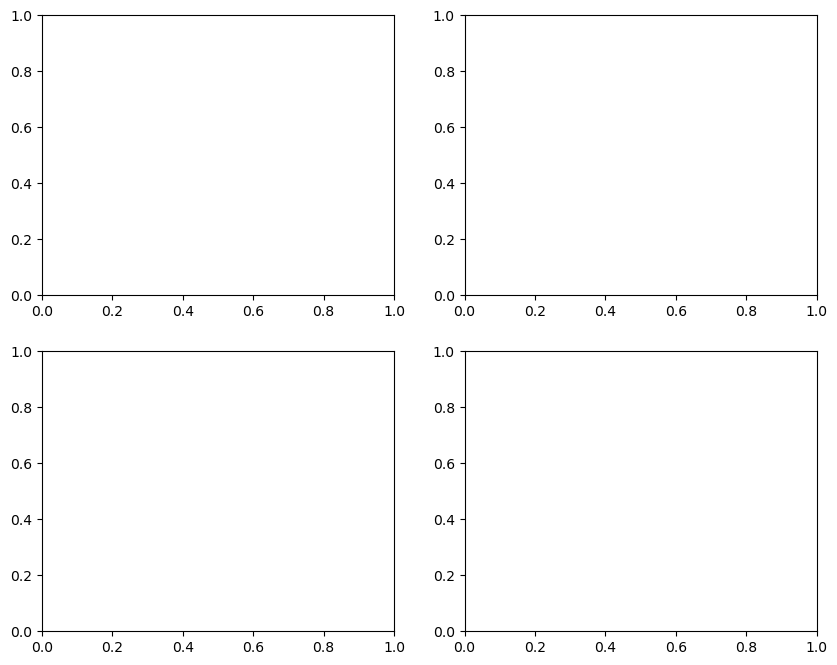

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(20, 6))
# ax = ax.ravel()

# for i, metric in enumerate(["accuracy", "loss"]):
#     ax[i].plot(model.history.history[metric])
#     ax[i].plot(model.history.history["val_" + metric])
#     ax[i].set_title("Model {}".format(metric))
#     ax[i].set_xlabel("epochs")
#     ax[i].set_ylabel(metric)
#     ax[i].legend(["train", "validation"])

# create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

# plot the training and validation accuracy for facial
axes[0][0].plot(model.history.history['facial_accuracy'], label='train')
axes[0][0].plot(model.history.history['val_facial_accuracy'], label='val')
axes[0][0].set_title('Facial Accuracy')
axes[0][0].legend()

# plot the training and validation loss for facial
axes[0][1].plot(model.history.history['facial_loss'], label='train')
axes[0][1].plot(model.history.history['val_facial_loss'], label='val')
axes[0][1].set_title('Facial Loss')
axes[0][1].legend()

# plot the training and validation accuracy for brain
axes[1][0].plot(model.history.history['brain_accuracy'], label='train')
axes[1][0].plot(model.history.history['val_brain_accuracy'], label='val')
axes[1][0].set_title('Brain Accuracy')
axes[1][0].legend()

# plot the training and validation loss for brain
axes[1][1].plot(model.history.history['brain_loss'], label='train')
axes[1][1].plot(model.history.history['val_brain_loss'], label='val')
axes[1][1].set_title('Brain Loss')
axes[1][1].legend()

plt.tight_layout()
plt.show()

In [ ]:
model.load_weights("project.h5")
predictions_facial = []
predictions_brain = []
for i in range(len(X_test)):
    prediction = model.predict(np.expand_dims(X_test[i], axis=0))[0]
    scores = [1 - prediction[0], prediction[0]]
    predictions_facial.append([prediction[0]["facial"]])
    predictions_brain.append([prediction[0]["brain"]])

print(predictions_facial[:2], predictions_brain[:2])

1/1 [==============================] - 0s 288ms/step


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
tests_facial=[]
for i in Y_f_test:
    tests_facial.append([i])
tests_facial[:2]

In [ ]:
tests_brain=[]
for i in Y_b_test:
    tests_brain.append([i])
tests_brain[:2]

In [ ]:
m = BinaryAccuracy()
m.update_state(tests_facial, predictions_facial)
acc_facial = m.result().numpy() * 100

m.reset_state()
m.update_state(tests_brain, predictions_brain)
acc_brain = m.result().numpy() * 100

print("Facial Accuracy: " + acc_facial)
print("Brain Accuracy: " + acc_brain)

99.68847632408142

In [ ]:
f1_facial = f1_score(tests_facial, predictions_facial)
f1_brain = f1_score(tests_brain, predictions_brain)
print("Facial F1 score: " + f1_facial)
print("Brain F1 score: " + f1_brain)